In [1]:
import pandas as pd
import numpy as np

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=1, releaselevel='final', serial=0)

In [2]:
def plot_features(booster,figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster = booster, ax = ax)

读取数据

In [3]:
df_items = pd.read_csv('./data/items.csv')
df_categories = pd.read_csv('./data/item_categories.csv')
df_shops = pd.read_csv('./data/shops.csv')
df_train = pd.read_csv('./data/sales_train_v2.csv')
df_test = pd.read_csv('./data/test.csv')

查看数据列

In [4]:
print("items columns:",df_items.columns)
print("categories columns:",df_categories.columns)
print("shops columns:",df_shops.columns)
print("train columns:",df_train.columns)
print("test columns:",df_test.columns)

items columns: Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
categories columns: Index(['item_category_name', 'item_category_id'], dtype='object')
shops columns: Index(['shop_name', 'shop_id'], dtype='object')
train columns: Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
test columns: Index(['ID', 'shop_id', 'item_id'], dtype='object')


查看训练数据中日销量与商品价格的分布

In [5]:
df_train.item_cnt_day.describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [6]:
df_train.item_price.describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

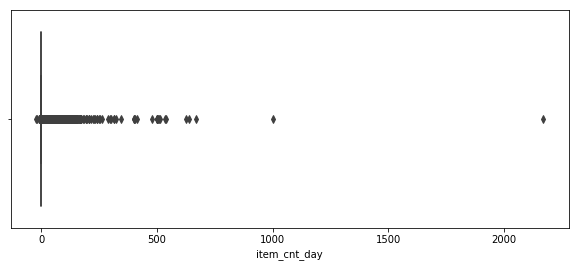

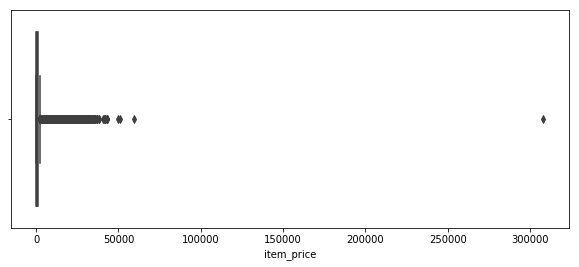

In [7]:
plt.figure(figsize=(10,4))
#plt.xlim(-100, 3000)
sns.boxplot(x=df_train.item_cnt_day)

plt.figure(figsize=(10,4))
#plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=df_train.item_price)

处理异常点

In [8]:
print(len(df_train[df_train.item_cnt_day<0]))#退还则销量为负
print(len(df_train[df_train.item_price<0]))
df_train[df_train.item_price<0]

7356
1


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [9]:
#以同一商品中值填充价格为负的商品
median = df_train[(df_train.shop_id==32)&(df_train.item_id==2973)&(df_train.date_block_num==4)&(df_train.item_price>0)].item_price.median()
df_train.loc[df_train.item_price<0, 'item_price'] = median

In [10]:
#去除离群点
df_train = df_train[df_train.item_price<100000]
df_train = df_train[df_train.item_cnt_day<1001]

In [11]:
len(df_train)

2935847

 合并同名商店

In [12]:
# Якутск Орджоникидзе, 56
df_train.loc[df_train.shop_id == 0, 'shop_id'] = 57
df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
df_train.loc[df_train.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
df_train.loc[df_train.shop_id == 10, 'shop_id'] = 11
df_test.loc[df_test.shop_id == 10, 'shop_id'] = 11

### 特征工程

In [16]:
#matrix 为存储特征的新dataframe
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = df_train[df_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
matrix.reset_index(drop=True, inplace=True)
time.time() - ts

20.896528005599976

In [17]:
len(matrix)

10913804

In [18]:
matrix.head()

,date_block_num,shop_id,item_id
0,0,2,19
1,0,2,27
2,0,2,28
3,0,2,29
4,0,2,32


In [19]:
#item_cnt_month:该商店该商品月销量
ts = time.time()
group = df_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

13.667861223220825

In [20]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


#### 1. item_id features:  
a.Lags  
b.Release date  
c.Last month sale  
d.Days on sale  
e.Neighbors (items with id 1000 and 1001 could be somehow similar - genre, type, release date)

#### 2.shop_id features

a.Lags (shop_id/shp_cnt_mth)  
b.Opening month (possible opening sales)  
c.Closed Month (possible stock elimination)

#### 3.price

a.Price category (1 /10 /20$/ etc.) - obviously (or not obviously), items with smaller price have greater volumes  
b.Discount and Discount duration  
c.Price lag (shows discount)  
d.Price correction (rubl/usd pair)  
e.Shop Revenue

#### 4.dates

a.Weekends and holidays sales (to correct monthly sales)  
b.Number of days in the month (to correct monthly sales)  
c.Month number (for seasonal items)

#### 5. shop info

a.Shop City  
b.Shop Type

#### 6. item info

a.item name  
b.Encoded aditional feature

#### 7.category info

a.Section  
b.Main Category name  
c.Main SubCategory name  
d.Secondary SubCategory name

#### 8.test set

The key to my success was the analysis of Test test data.  
We have three groups of items:  
(1)Item/shop pairs that are in train  
(2)Items without any data  
(3)Items that are in train